In [2]:
import glob 
from collections import defaultdict
from util_kitti import kitti_label_file_parser, kitti_calib_file_parser # , P2_tf, P2
import matplotlib.pyplot as plt
import statistics 
import numpy as np
import cv2
from util_kitti import init_img_plt, draw_birdeyes, draw_corner_2D, kitti_calib_file_parser
import os 
from math import sqrt

LABEL_DIR = "/home/lab530/KenYu/kitti/training/label_2/"
CALIB_DIR = "/home/lab530/KenYu/kitti/training/calib/"

# Is all calib txt the same? NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

In [3]:
# import os
# import pprint 
# import cv2
# P2_dict = {
#             '[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]\n ' +
#              '[0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]\n ' +
#              '[0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]':'A',
#             '[[ 7.070493e+02  0.000000e+00  6.040814e+02  4.575831e+01]\n ' +
#              '[ 0.000000e+00  7.070493e+02  1.805066e+02 -3.454157e-01]\n ' +
#              '[ 0.000000e+00  0.000000e+00  1.000000e+00  4.981016e-03]]':'B',
#             '[[ 7.183351e+02  0.000000e+00  6.003891e+02  4.450382e+01]\n ' + 
#              '[ 0.000000e+00  7.183351e+02  1.815122e+02 -5.951107e-01]\n ' + 
#              '[ 0.000000e+00  0.000000e+00  1.000000e+00  2.616315e-03]]':'C',
#             '[[ 7.188560e+02  0.000000e+00  6.071928e+02  4.538225e+01]\n ' +
#              '[ 0.000000e+00  7.188560e+02  1.852157e+02 -1.130887e-01]\n ' +
#              '[ 0.000000e+00  0.000000e+00  1.000000e+00  3.779761e-03]]':'D'}

# shape_dict_inv  = {(375, 1242, 3): 'A',
#                    (370, 1224, 3): 'B',
#                    (374, 1238, 3): 'C',
#                    (376, 1241, 3): 'D'}
# shape_dict = {'A': (375, 1242, 3),
#               'B': (370, 1224, 3),
#               'C': (374, 1238, 3),
#               'D': (376, 1241, 3)}

# type_dict_inv = {'A':[], 'B':[], 'C':[], 'D':[]}
# type_dict     = {}
# for fn in os.listdir("/home/lab530/KenYu/kitti/training/calib/"):
#     name = fn.split('.')[0]
#     P2 = kitti_calib_file_parser(f"/home/lab530/KenYu/kitti/training/calib/{fn}")
#     img = cv2.imread(f"/home/lab530/KenYu/kitti/training/image_2/{name}.png")

#     if P2_dict[str(P2)] == shape_dict_inv[img.shape]:
#         type_dict[name] = P2_dict[str(P2)]
#         type_dict_inv[ P2_dict[str(P2)] ].append(name)
#     else:
#         print(P2_dict[str(P2)])
#         print(shape_dict_inv[img.shape])
#         raise ValueError

# # pprint.pprint(type_dict_inv)
# for i in type_dict_inv:
#     print(f"{i}:{len(type_dict_inv[i])}")
# # A:6057
# # B:770
# # C:358
# # D:296
# pprint.pprint(type_dict)

# import pickle
# with open(f"type_dict.pkl", 'wb') as f:
#     pickle.dump(type_dict, f)
# print(f"Write type_dict to type_dict.pkl")

[[7.43613733e+02 0.00000000e+00 6.28209262e+02 4.62297250e+01]
 [0.00000000e+00 7.38854605e+02 1.77002496e+02 2.21572198e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 2.74588400e-03]]
[[ 7.39397961e+02  0.00000000e+00  6.31719111e+02  4.78518275e+01]
 [ 0.00000000e+00  7.33802517e+02  1.87336579e+02 -3.58485483e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  4.98101600e-03]]
[[ 7.42705111e+02  0.00000000e+00  6.20757712e+02  4.60136426e+01]
 [ 0.00000000e+00  7.37541921e+02  1.86365467e+02 -6.11022751e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.61631500e-03]]
[[ 7.41446962e+02  0.00000000e+00  6.26274604e+02  4.68084448e+01]
 [ 0.00000000e+00  7.34150809e+02  1.89156460e+02 -1.15494843e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  3.77976100e-03]]


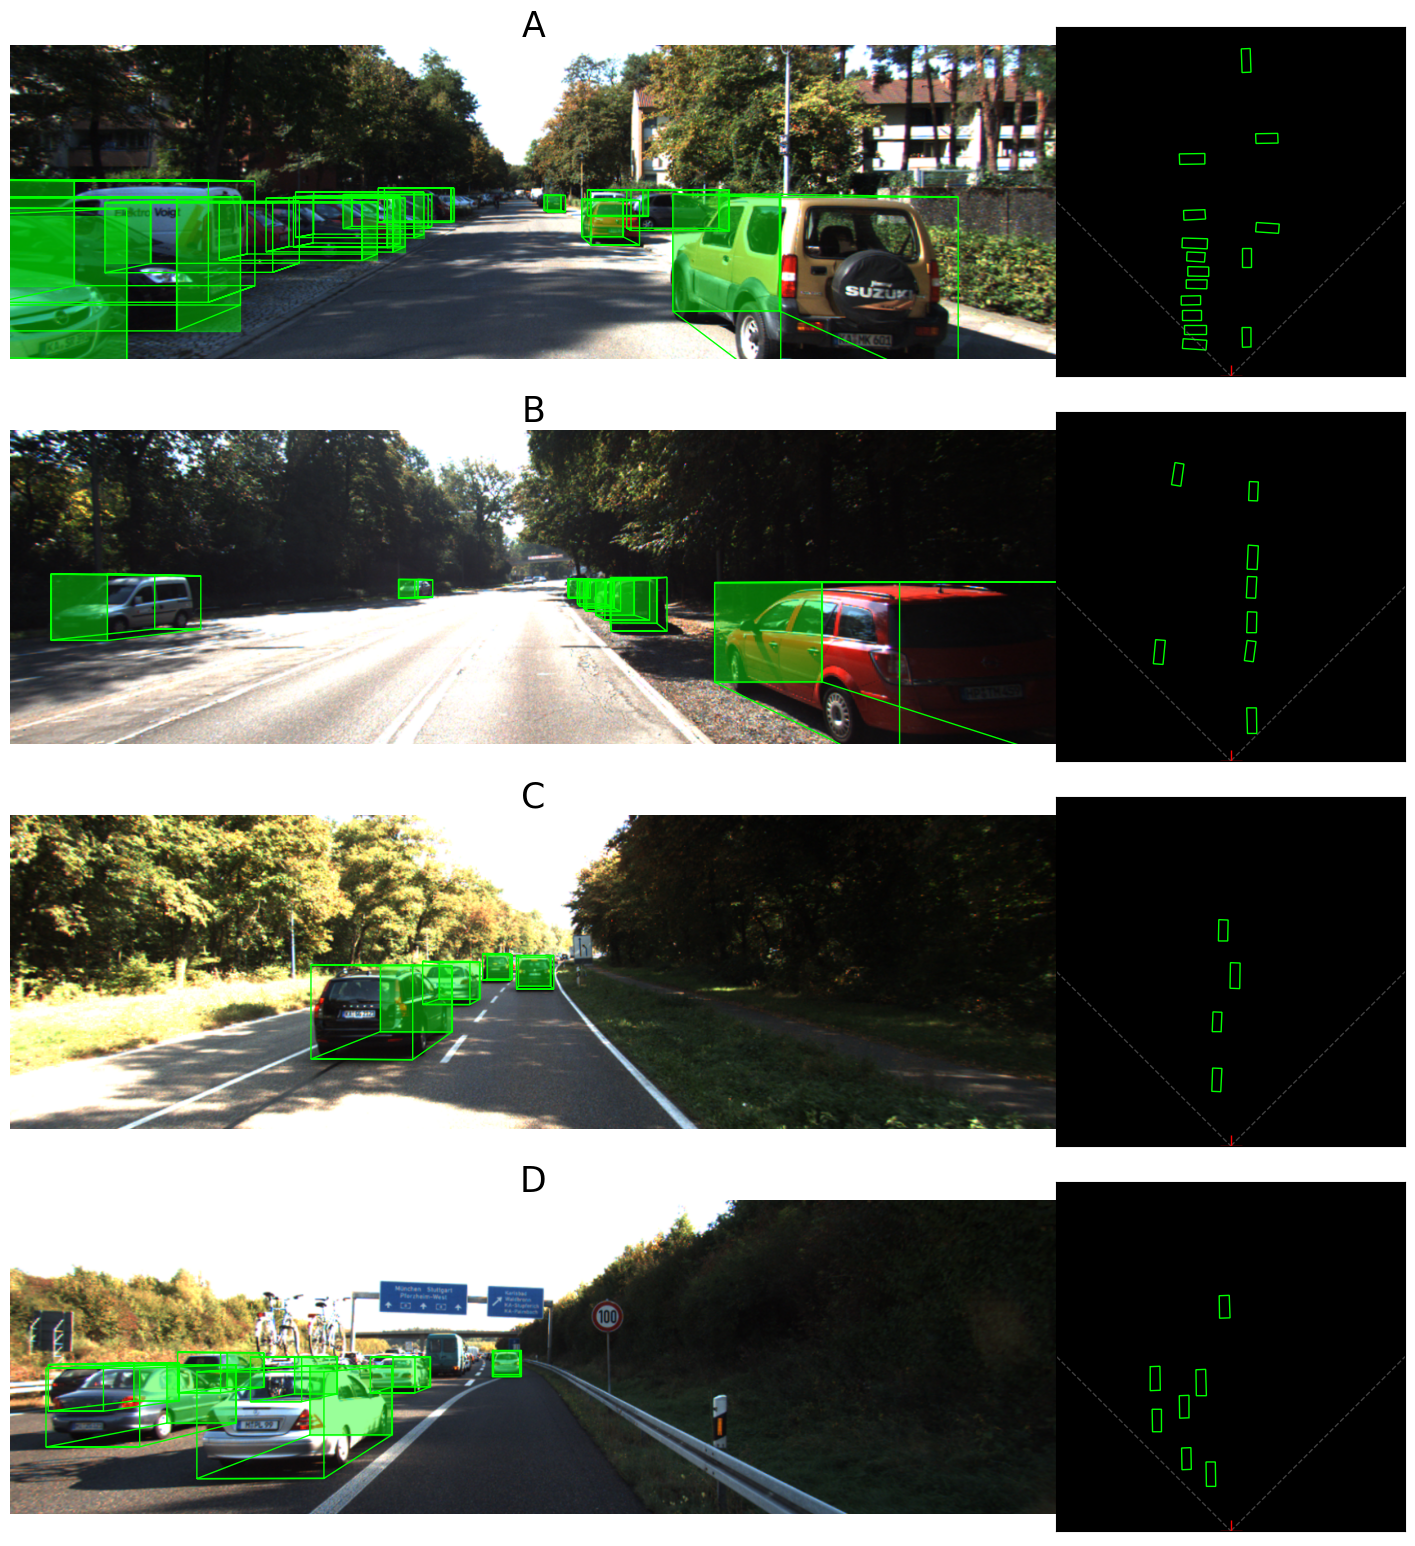

In [4]:
img_dict = {'A': '000169', 'B': '000338', 'C': '000259', 'D': '003563'}
mappppp = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}


imgs = []
P2s = []
for type in img_dict:
    img = cv2.imread(f"/home/lab530/KenYu/kitti/training/image_2/{img_dict[type]}.png")
    P2 = kitti_calib_file_parser(f"/home/lab530/KenYu/kitti/training/calib/{img_dict[type]}.txt")
    
    
    img_ori_h, img_ori_w, _ = img.shape
    # Resize
    P2[0, :] *= 1280  / img_ori_w
    P2[1, :] *= 384   / img_ori_h
    print(P2)
    img = cv2.resize(img, (1280, 384))
    
    imgs.append(img)
    P2s.append(P2)

axs = init_img_plt(imgs, titles = ['A', 'B', 'C', 'D'])

ANO_DIR = "/home/lab530/KenYu/kitti/training/label_2/"

for i in range(4):
    objs = kitti_label_file_parser(os.path.join(ANO_DIR, f"{img_dict[mappppp[i] ]}.txt"), tf_matrix = P2s[i])

    # Draw annotation on image
    for obj in objs:
        if obj.category == "Car":
            draw_birdeyes(axs[i][1], obj, color = (0,1,0), title = "123", is_print_confident = False)
            draw_corner_2D(axs[i][0], obj.corner_2D, color = (0,1,0), is_draw_front = True, )

Number of total ground trues = 51865
Categories: 
Van: 2914
Car: 28742
Misc: 973
DontCare: 11295
Truck: 1094
Pedestrian: 4487
Cyclist: 1627
Tram: 511
Person_sitting: 222
Truncated Objects:
Number of truncated object = 4067, 7.84%
Occluded objects:
1: 8184  (28.47%)
0: 13457  (46.82%)
3: 928  (3.23%)
2: 6173  (21.48%)
Dimension: 
Average height = 1.526
Average width  = 1.629
Average length = 3.884
Std height = 0.137
Std width  = 0.102
Std length = 0.426
Average height = 1.71
Mean of y_3d = 1.7097738501148145
Mean of z_3d = 28.01284044255793
Std of y_3d = 0.3857424915081378
Std of z_3d = 16.32088065975966


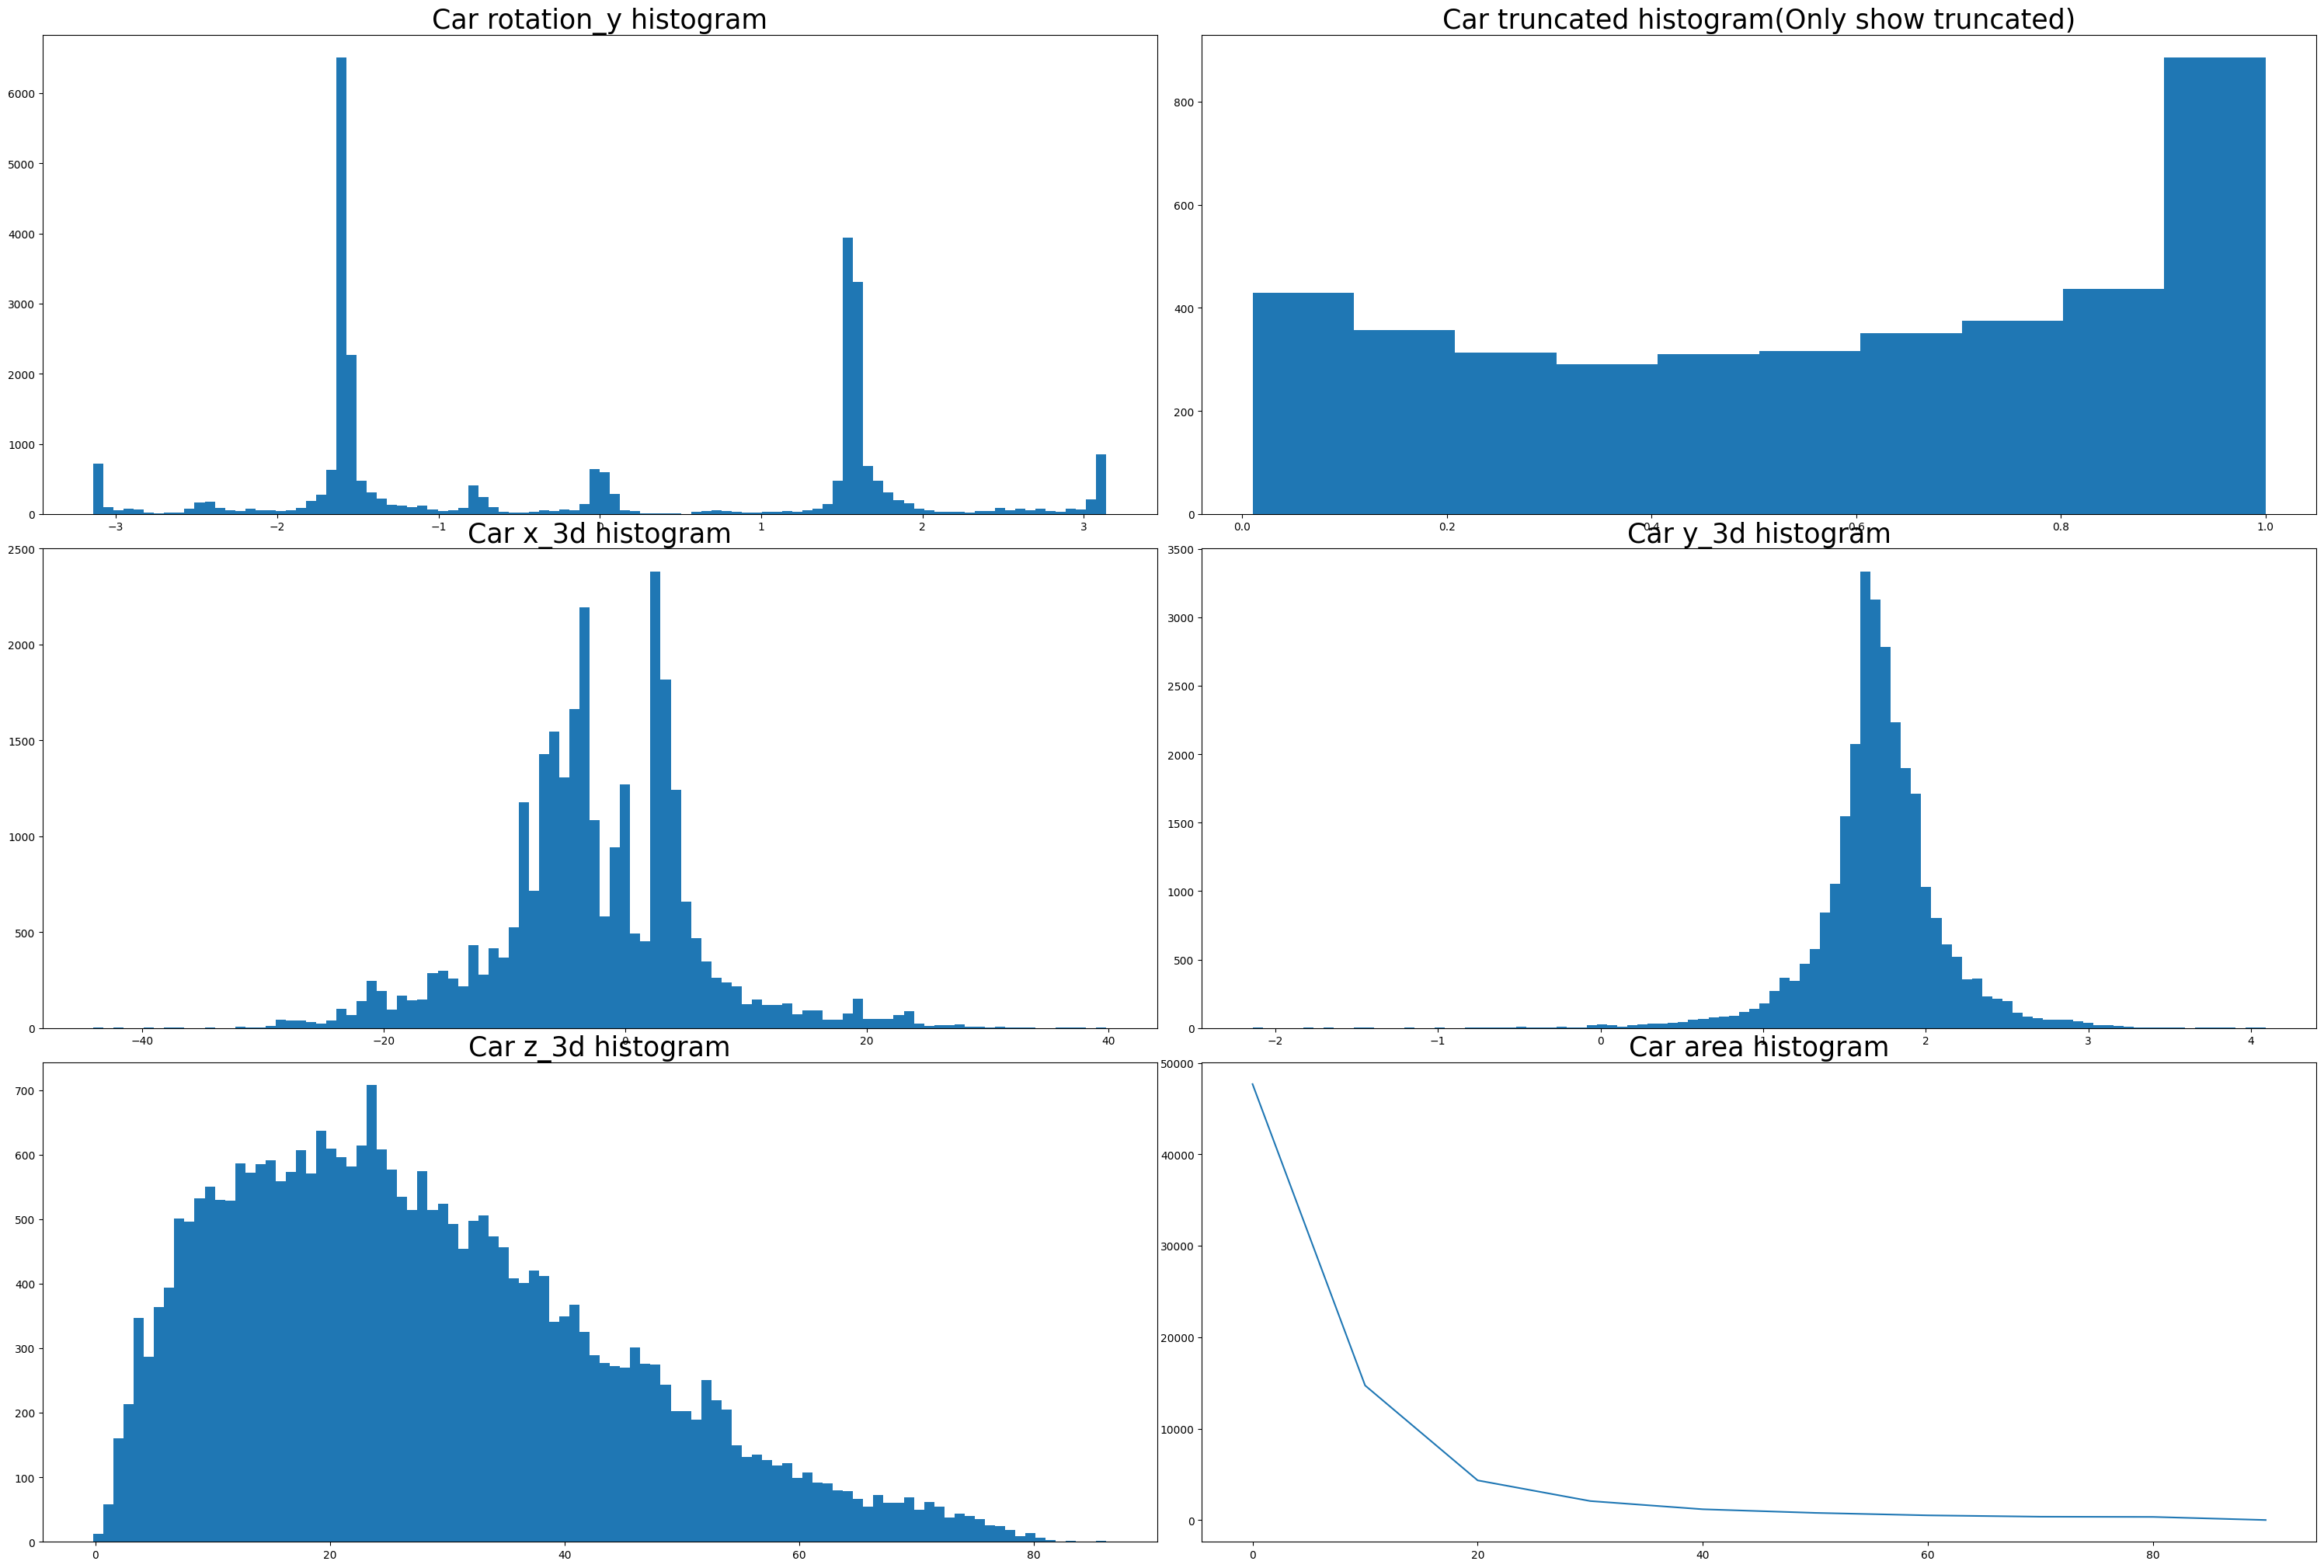

In [5]:
objs = []
for fn in glob.glob(LABEL_DIR + "*.txt"):
    tf_matrix = kitti_calib_file_parser( os.path.join(CALIB_DIR, fn.split("/")[-1]) )
    objs += kitti_label_file_parser(fn, tf_matrix)
print(f"Number of total ground trues = {len(objs)}")
print("=====================================")
kitti_calib_file_parser
# Show category
print("Categories: ")
cls_dict = defaultdict(int)
for obj in objs:
    cls_dict[obj.category] += 1

for cls in cls_dict:
    print(f"{cls}: {cls_dict[cls]}")
print("=====================================")

# Show truncated objects
print("Truncated Objects:")
N_BIN_TRUNCATED = 10
x_truncated = []
not_truncated_count = 0 
for obj in objs:
    if obj.category == "Car":
        if obj.truncated == 0.0: # Not truncated
            not_truncated_count += 1
        else:
            x_truncated.append(obj.truncated)
print(f"Number of truncated object = {len(x_truncated)}, {round(100*len(x_truncated)/len(objs), 2)}%")

print("=====================================")
print("Occluded objects:")
occ_dict = defaultdict(int)
for obj in objs:
    if obj.category == "Car":
        occ_dict[obj.occluded] += 1
for i in occ_dict:
    print(f"{i}: {occ_dict[i]}  ({round(100*occ_dict[i]/cls_dict['Car'],2)}%)")
print("=====================================")
print("Dimension: ")
avg_h, avg_w, avg_l  = 0, 0, 0

for obj in objs:
    if obj.category == "Car":
        avg_h += obj.h / cls_dict['Car']
        avg_w += obj.w / cls_dict['Car']
        avg_l += obj.l / cls_dict['Car']
print(f"Average height = {round(avg_h, 3)}")
print(f"Average width  = {round(avg_w, 3)}")
print(f"Average length = {round(avg_l, 3)}")

# Calculate STD
print("=====================================")
std_h, std_w, std_l = 0, 0, 0
for obj in objs:
    if obj.category == "Car":
        std_h += (obj.h - avg_h)**2 / cls_dict['Car']
        std_w += (obj.w - avg_w)**2 / cls_dict['Car']
        std_l += (obj.l - avg_l)**2 / cls_dict['Car']
std_h = sqrt(std_h)
std_w = sqrt(std_w)
std_l = sqrt(std_l)
print(f"Std height = {round(std_h, 3)}")
print(f"Std width  = {round(std_w, 3)}")
print(f"Std length = {round(std_l, 3)}")

# TODO, BTW, I think using validation data to do statistic is slight cheating
print("=====================================")
avg_y_3d = 0
for obj in objs:
    if obj.category == "Car":
        avg_y_3d += obj.y3d / cls_dict['Car']
print(f"Average height = {round(avg_y_3d, 3)}")

# Show rotation_y histogram
N_BIN_ROTATION_Y = 100
x_rotation_y = []
for obj in objs:
    if obj.category == "Car":
        x_rotation_y.append(obj.rot_y)

# Show x_3d 
N_BIN_X_3D = 100
x_x_3d = []
for obj in objs:
    if obj.category == "Car":
        x_x_3d.append(obj.x3d)

# Show y_3d 
N_BIN_Y_3D = 100
x_y_3d = []
for obj in objs:
    if obj.category == "Car":
        x_y_3d.append(obj.y3d)

# Show z_3d 
N_BIN_Z_3D = 100
x_z_3d = []
for obj in objs:
    if obj.category == "Car":
        x_z_3d.append(obj.z3d)

# Show area 
# N_BIN_AREA_3D = 100
area_z_bin = [[] for _ in range(10)]
for obj in objs:
    if obj.category == "Car":
        area_z_bin[ int(obj.z3d/10) ].append(obj.area)
new_bin = []
for i in area_z_bin:
    try: 
        new_bin.append(sum(i) / len(i))
    except ZeroDivisionError:
        new_bin.append(0)


# Draw histogram
fig, ax = plt.subplots(3, 2, figsize=(30, 20))
fig.set_facecolor('white')
fig.tight_layout()

ax[0, 0].set_title("Car rotation_y histogram", fontsize=25)
ax[0, 0].hist(x_rotation_y, bins=N_BIN_ROTATION_Y)
ax[0, 1].set_title("Car truncated histogram(Only show truncated)", fontsize=25)
ax[0, 1].hist(x_truncated, bins=N_BIN_TRUNCATED)
ax[1, 0].set_title("Car x_3d histogram", fontsize=25)
ax[1, 0].hist(x_x_3d, bins=N_BIN_X_3D)
ax[1, 1].set_title("Car y_3d histogram", fontsize=25)
ax[1, 1].hist(x_y_3d, bins=N_BIN_Y_3D)
ax[2, 0].set_title("Car z_3d histogram", fontsize=25)
ax[2, 0].hist(x_z_3d, bins=N_BIN_Z_3D)
ax[2, 1].set_title("Car area histogram", fontsize=25)
ax[2, 1].plot(list(range(0, 100 ,10)), new_bin)

print(f"Mean of y_3d = {statistics.mean(x_y_3d)}")
print(f"Mean of z_3d = {statistics.mean(x_z_3d)}")

print(f"Std of y_3d = {statistics.stdev(x_y_3d)}")
print(f"Std of z_3d = {statistics.stdev(x_z_3d)}")



## Calcualate alpha angle


In [6]:
import math
for obj in objs:
    if obj.category == "Car":
        x_x_3d.append(obj.x3d)
        alpha_my = obj.rot_y + math.atan2(obj.z3d, obj.x3d) - math.pi/2

        # Constraint alpha_my in [-pi, pi]
        if alpha_my > math.pi: alpha_my -= 2*math.pi
        elif alpha_my < -math.pi: alpha_my += 2*math.pi

        if abs(alpha_my - obj.alpha) > 0.3:
            print(obj.alpha)
            print(alpha_my)

-3.14
3.138933319966662
3.14
-3.1404460190377588
-3.14
3.13597033102729
3.13
-3.1377173578538073
-3.07
3.1221185126271536


# Check relationship between u, y, z

In [7]:
'''
I want to know whether P2 precise -> It's actually very precise with only 0.4mm error
No wonder GAC deson't regress x3d, y3d becuase it's very precise to get it from (cx, cy)
cz is the only variable we need to seriously regress
'''
sum_diff = 0
sum_abs_diff = 0
n_gt = 0
for fn in glob.glob(LABEL_DIR + "*.txt"):
    P2 = kitti_calib_file_parser( os.path.join(CALIB_DIR, fn.split("/")[-1]) )
    objs = kitti_label_file_parser(fn, P2)
    for obj in objs:
        if obj.category == "Car":
            y3d = obj.cz * (obj.cy - P2[1, 2] ) / P2[1, 1] + obj.h/2
            sum_diff += y3d - obj.y3d
            sum_abs_diff += abs(y3d - obj.y3d)
            n_gt += 1
print(f"Avg diff = {sum_diff / n_gt}")
print(f"Avg abs diff = {sum_abs_diff / n_gt}")

Avg diff = -0.00047593679969879475
Avg abs diff = 0.00047593679969879475


# Check 2D bounding box vs 3D bounding box project to image plane

In [8]:
'''
I want to know whether 2D bbox <--> 3D bounding box projection has a big difference
But actually its has very little error in this experiement 
Note that I have to ignore all truncated objects in this experiment 
because truncated object is bounded to have big different 
'''

xc_diff_sum = 0
yc_diff_sum = 0
h_diff_sum = 0
w_diff_sum = 0
n_gt = 0
for fn in glob.glob(LABEL_DIR + "*.txt"):
    P2 = kitti_calib_file_parser( os.path.join(CALIB_DIR, fn.split("/")[-1]) )
    objs = kitti_label_file_parser(fn, P2)
    for obj in objs:
        if obj.category == "Car" and obj.truncated == 0.0: # Ignore truncated object
            xmin = obj.corner_2D[0].min()
            ymin = obj.corner_2D[1].min()
            xmax = obj.corner_2D[0].max()
            ymax = obj.corner_2D[1].max()
            xc_f3d , yc_f3d = ( (xmin + xmax) / 2, (ymin + ymax) / 2 )
            w_f3d  , h_f3d  = ( (xmax - xmin)    , (ymax - ymin)     )
            xc_lab , yc_lab = ( (obj.xmin + obj.xmax) / 2, (obj.ymin + obj.ymax) / 2 )
            w_lab  , h_lab  = ( (obj.xmax - obj.xmin)    , (obj.ymax - obj.ymin)     )
            
            xc_diff_sum += abs(xc_lab - xc_f3d)
            yc_diff_sum += abs(yc_lab - yc_f3d)
            h_diff_sum  += abs(h_lab - h_f3d)
            w_diff_sum  += abs(w_lab - w_f3d)

            n_gt += 1

print(f"Avg xc abs diff = {xc_diff_sum / n_gt}")
print(f"Avg yc abs diff = {yc_diff_sum / n_gt}")
print(f"Avg h abs diff = {h_diff_sum / n_gt}")
print(f"Avg w abs diff = {w_diff_sum / n_gt}")
print(f"Number of Ground true  = {n_gt}")

Avg xc abs diff = 0.7091097917575874
Avg yc abs diff = 0.7225194765791833
Avg h abs diff = 0.7397038768332127
Avg w abs diff = 0.5744506009682684
Number of Ground true  = 24675


# bbox statistic

In [14]:
# 'sizes' : [4 * 2 ** i for i in range(3, 8)], # [32, 64, 128, 256, 512] # base_size
# 'ratios': np.array([0.5, 1, 2.0])
# 'scales': np.array([2 ** (i / 3.0) for i in range(3)]), # [1, 1.26, 1,587]
import math
import pprint
sizes = [32, 64, 128, 256, 512]
# ratios = [0.5, 1, 2.0]
ratios = [1, 2.0, 3.0]
scales = [2**(0/3), 2**(1/3), 2**(2/3)]

cluster_dict = {}
for size in sizes:
    for scale in scales:
        for ratio in ratios:
            # (w, h)
            base = scale * size # area = base**2
            cluster_dict[ f"size_{size}_ratio_{ratio}_scales_{round(scale, 2)}" ] = [base*math.sqrt(ratio), 
                                                                                     base/math.sqrt(ratio), 
                                                                                     []] # [w, h, [z3d, z3d ,z3d, ....]]

for fn in glob.glob(LABEL_DIR + "*.txt"):
    P2 = kitti_calib_file_parser( os.path.join(CALIB_DIR, fn.split("/")[-1]) )
    objs = kitti_label_file_parser(fn, P2)
    for obj in objs:
        if obj.category == "Car":
            width  = obj.xmax - obj.xmin
            height = obj.ymax - obj.ymin
            
            # Get cloest key
            cloest_key = None
            cloest_diff = 99999999999999999999
            for key in cluster_dict:
                diff = abs( width  - cluster_dict[key][0] ) + abs( height - cluster_dict[key][1] )
                if diff < cloest_diff:
                    cloest_key = key
                    cloest_diff = diff
            
            # 
            cluster_dict[cloest_key][2].append(obj.z3d)

for size in sizes:
    for scale in scales:
        for ratio in ratios:
            key = f"size_{size}_ratio_{ratio}_scales_{round(scale, 2)}"
            
            num_gt = len(cluster_dict[key][2])
            
            if num_gt != 0:
                avg_z3d = sum(cluster_dict[key][2]) / num_gt
                for z in cluster_dict[key][2]:
                    std_z3d = math.sqrt( (1/num_gt) * (z - avg_z3d)**2 )
            else:
                avg_z3d = 0
                std_z3d = 0
            print( (cluster_dict[key][0], cluster_dict[key][1]) )
            print(f"avg_z3d = {avg_z3d}")
            print(f"std_z3d = {std_z3d}")
            
            
            
            

(32.0, 32.0)
avg_z3d = 50.18889870689651
std_z3d = 0.11434497021103898
(45.254833995939045, 22.62741699796952)
avg_z3d = 48.796476085761405
std_z3d = 0.1855468430713285
(55.42562584220407, 18.475208614068027)
avg_z3d = 55.18709677419358
std_z3d = 0.017964372803089563
(40.31747359663594, 40.31747359663594)
avg_z3d = 31.874483582089553
std_z3d = 0.1775248207475465
(57.01751796098172, 28.508758980490857)
avg_z3d = 37.16320117474307
std_z3d = 0.11480195641428795
(69.83191270219017, 23.27730423406339)
avg_z3d = 44.71137214137213
std_z3d = 0.48234391197636195
(50.79683366298238, 50.79683366298238)
avg_z3d = 25.6985997171146
std_z3d = 0.155609140400112
(71.83757109179987, 35.91878554589993)
avg_z3d = 30.621214057507995
std_z3d = 0.003569609928293746
(87.98269676791055, 29.32756558930352)
avg_z3d = 36.32444968553457
std_z3d = 0.029519350180028187
(64.0, 64.0)
avg_z3d = 20.741569173630438
std_z3d = 0.12640841944346962
(90.50966799187809, 45.25483399593904)
avg_z3d = 24.84938379102477
std_z3d = 